In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as random
import math
from agents import *
from numba import njit
from time import perf_counter
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as anim

In [2]:
class Arbiter:
    '''
    Manage running tournament. Base class. 
    Inherited, inheriting class defines how games are decided.
    Inheriting class also decides how the agent array is created. Agent array needs to be created at initialization
    '''
    def manageTournament(self, Nrounds):
        for _ in range(Nrounds):
            self.manageRound(self.generateRound())

    def manageRound(self, games):
        '''
        games: Array of 2-long arrays of matchups
        scores array: row is agent, column is opponent
        '''
        scores = np.zeros((len(self.agents),len(self.agents)))
        for game in games:
            a1, a2 = game[0], game[1]
            a1score, a2score = playNIterations(self.agents[a1],self.agents[a2], self.iters)
            scores[game[0], game[1]] += a1score
            scores[game[1], game[0]] += a2score
        self.score += scores

In [3]:
class NetworkArbiter(Arbiter):
    '''
    For managing network based interaction. Adjacency table is 2d
    '''
    def __init__(self, iterations, agents):
        self.iters = iterations # integer
        self.agents = agents # 1d list of agents
        self.score = np.zeros((len(self.agents), len(self.agents)))
    
    def constructTable(self):
        '''
        Builds adjacency table by generating random probability vectors for each agent
        '''
        N = len(self.agents)
        adjMat = (np.ones((N,N)) - np.eye(N)) / (N-1)
        for n in range(N): # Probablity of interacting with every other agent
            randomVec = random.rand(N - 1)
            probVec = randomVec / np.sum(randomVec)
            adjMat[0:n,n] = probVec[:n]
            adjMat[n+1:,n] = probVec[n:]
        self.adjMat = adjMat

    def generateRound(self):
        playersLeft = set(range(len(self.agents))) # Players 0-n set
        playersSeen = set()
        games = []
        adjMat = self.adjMat # Copied because table is adjusted
        while len(playersLeft) > 1:
            # Choose first agent and track that agent has been seen
            player = random.choice(list(playersLeft))
            playersLeft.remove(player)
            playersSeen.add(player)
            # First agent interaction weights.
            # Set probability of interacting with already taken agents to 0
            weights = np.delete(adjMat[:,player], list(playersSeen))
            weights /= np.sum(weights)
            # Choose opponent
            opponent = random.choice(list(playersLeft), p=weights)
            playersLeft.remove(opponent)
            playersSeen.add(opponent)
            games.append(np.array([player, opponent]))
        return games

    def displayScores(self):
        plt.imshow(self.score, cmap = 'YlOrRd')

    def displayAdjMat(self):
        np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
        display(self.adjMat)

array([[0.000, 0.085, 0.089, 0.137, 0.148, 0.263, 0.299, 0.128],
       [0.126, 0.000, 0.023, 0.116, 0.017, 0.073, 0.015, 0.182],
       [0.164, 0.140, 0.000, 0.168, 0.004, 0.003, 0.064, 0.179],
       [0.221, 0.154, 0.058, 0.000, 0.210, 0.257, 0.249, 0.039],
       [0.161, 0.071, 0.055, 0.223, 0.000, 0.117, 0.155, 0.108],
       [0.212, 0.113, 0.177, 0.094, 0.296, 0.000, 0.217, 0.174],
       [0.078, 0.205, 0.146, 0.140, 0.233, 0.196, 0.000, 0.191],
       [0.038, 0.232, 0.452, 0.122, 0.092, 0.090, 0.002, 0.000]])

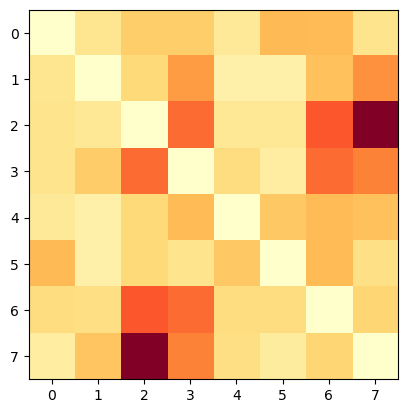

In [4]:
net = NetworkArbiter(10, [Du(), Du(), TFT(), TFT(), Du(), Du(), TFT(), TFT()])
net.constructTable()
net.manageTournament(100)
#net.scores = net.score / net.adjMat
net.displayAdjMat()
net.displayScores()

In [5]:
from perlin_numpy import generate_fractal_noise_2d, generate_perlin_noise_2d

def perlinGrid(X, Y):
    agents = list(agentTypes().values())
    random.shuffle(agents)
    noise = generate_fractal_noise_2d((Y,X), (4,4))
    noise *= len(agents)
    noise += len(agents)
    noise /= 2
    noise = np.floor(noise).astype(int)
    #print(noise)
    agentgrid = [[] for _ in range(Y)]
    #print(noise)
    for idr, row in enumerate(noise):
        for item in row:
            agentgrid[idr].append(agents[item][0]())
    agentgrid = np.array(agentgrid)
    return agentgrid

def noiseGrid(X, Y):
    agents = list(agentTypes().values())
    print(agents)
    grid = np.floor(random.rand(Y,X)*(len(agents))).astype(int)
    agentgrid = [[] for _ in range(Y)]
    for idr, row in enumerate(grid):
        for item in row:
            agentgrid[idr].append(agents[item]())
    agentgrid = np.array(agentgrid)
    return agentgrid

In [6]:
class GridArbiter(Arbiter):
    '''
    For managing grid based tournaments
    '''
    def __init__(self, iterations, agents, error=None, neighborhoodSize=1):
        self.iters = iterations
        self.agents = agents # 2d grid of agents
        self.score = np.zeros(agents.shape)
        self.buildAdjMat(neighborhoodSize=neighborhoodSize)
        self.error = error

    def buildAdjMat(self, neighborhoodSize=1):
        '''
        Creates a grid of tuples - ([neighbor i indices], [probability of interacting with i])
        Based on a moore neighborhood
        '''
        start = perf_counter()
        Y, X = self.agents.shape
        adj = [[([],[]) for _ in range(X)] for _ in range(Y)]
        for y in range(Y):
            for x in range(X):
                # Agent (x,y). [xMin, xMax), [yMin, yMax)
                xMin, xMax = (max(x-neighborhoodSize, 0), min(x+neighborhoodSize, X-1))
                yMin, yMax = (max(y-neighborhoodSize, 0), min(y+neighborhoodSize, Y-1))
                size = (xMax+1-xMin)*(yMax+1-yMin) - 1
                weights = np.ones(size) / size
                neighbors = []
                for yn in range(yMin, yMax + 1):
                    for xn in range(xMin, xMax + 1):
                        if (xn == x) and (yn == y): continue
                        neighbors.append(yn*Y + xn)
                adj[y][x] = (neighbors, weights)
        self.adjacencies = adj
        end = perf_counter()
        print(f'BuildAdjMat took {end-start}')

    def generateRound(self):
        '''
        Generate single tournament round
        '''
        start = perf_counter()
        Y, X = len(self.agents), len(self.agents[0])
        N = X*Y
        players = set(range(N))
        games = []
        while len(players) > 1:
            choice = int(np.floor(random.rand()*N))
            while choice not in players:
                choice = int(np.floor(random.rand()*N))
            players.remove(choice)
            neighbors, weights = self.adjacencies[choice//Y][choice % Y]
            opponent = neighbors[random.choice(list(range(len(neighbors))), p=weights)]
            failed = True
            for _ in range(10):
                if opponent in players: 
                    failed = False
                    break
                opponent = neighbors[random.choice(list(range(len(neighbors))), p=weights)]
            if failed: 
                #print(f'Failed for {choice}')
                continue
            #print(choice, opponent, list(players))
            players.remove(opponent)
            games.append([choice, opponent])
        end = perf_counter()
        print(f'Generate round took {end-start}')
        return games

    def manageTournament(self, rounds, snapshots=False, evolution=False):
        if snapshots != False:
            scoreSnaps = []
            agentSnaps = []
        Y, X= len(self.agents), len(self.agents[0])
        scores = np.zeros((Y,X))
        for n in range(rounds):
            start = perf_counter()
            games = self.generateRound()
            #print(games)
            for game in games:
                p1x, p1y = game[0] % X, game[0] // Y
                p2x, p2y = game[1] % X, game[1] // Y
                a1 = self.agents[p1y, p1x]
                a2 = self.agents[p2y, p2x]
                a1score, a2score = playNIterations(a1, a2, self.iters, self.error)
                scores[p1y, p1x] += a1score
                scores[p2y, p2x] += a2score
            end = perf_counter()
            print(f'Round {n} took {end-start}')
            if snapshots != False: 
                scoreSnaps.append(np.copy(scores))
                agentSnaps.append(self.getAgentArraySnapshot())
        if snapshots != False:
            self.scoreSnaps = scoreSnaps
            self.agentSnaps = agentSnaps
        self.scores = scores
        self.rounds = rounds

    def getAgentArraySnapshot(self):
        agentSnap = np.zeros(self.agents.shape)
        agenttypes = agentTypes()
        for idr, row in enumerate(self.agents):
            for idc, ag in enumerate(row):
                agentSnap[idr,idc] = agenttypes[ag.name][1]
        return agentSnap

    def displayScores(self, text=True):
        fig, ax = plt.subplots(figsize=(64,64))
        plt.title(f'Rounds: {self.rounds}')
        plt.imshow(self.scores, cmap = 'YlOrRd')
        plt.colorbar()
        if text:
            for idr, row in enumerate(self.agents):
                for idx, agent in enumerate(row):
                    if idr % 5 != 0 or idx % 5 != 0: continue
                    ax.text(idx, idr, f'{agent.name}\n{self.scores[idr, idx]}', ha="center", va="center", color="k", rotation=-20)
            
    def displayFrames(self, scoreFrames):
        fig, ax = plt.subplots(figsize=(32,32))
        im = plt.imshow(scoreFrames[0], cmap = 'YlOrRd')
        plt.colorbar()
        ani = anim.FuncAnimation(fig=fig, func=lambda frame: im.set_data(scoreFrames[frame]), frames=len(scoreFrames), interval=500)
        plt.show()

In [7]:
agents = np.array(
    [[Du(), Du(), Du(), Du()  ],
    [Du(), TFT(), TFT(), TFT()],
    [Du(), TFT(), Cu() , Cu() ],
    [Du(), TFT(), Cu(),  Cu()]]
)
agents = perlinGrid(100,100)

In [8]:
grid = GridArbiter(10, agents, error=0.01, neighborhoodSize=1)
grid.manageTournament(10,snapshots=10)

BuildAdjMat took 0.03680220898240805
Generate round took 0.30671266600256786
Round 0 took 0.36945983397890814
Generate round took 0.36328929199953564
Round 1 took 0.4262750420020893
Generate round took 0.2673280829912983
Round 2 took 0.32950270900619216
Generate round took 0.2698932499915827
Round 3 took 0.33197349999682046
Generate round took 0.2606548329931684
Round 4 took 0.32259341698954813
Generate round took 0.2809278749919031
Round 5 took 0.34379962499951944
Generate round took 0.2724147920089308
Round 6 took 0.33467691601254046
Generate round took 0.2716866669943556
Round 7 took 0.3335824999958277
Generate round took 0.26974762498866767
Round 8 took 0.33238358300877735
Generate round took 0.2720927920017857
Round 9 took 0.33435937500325963


In [20]:
du = Du()
print(du)
print(type(du)(short=False))

du
Defect unconditionally
